# Visualizing Spotify Streaming History

## Setting Up

I've already downloaded a JSON file from Spotify containing my streaming history (you can download yours [here](https://www.spotify.com/ca-en/account/privacy/)).

In this section, I will create two data frames: one for my streaming history (songs I've streamed and when I streamed them) and one for my playlists (information about each song in my playlists). 

For the streaming history data frame, I will load in the JSON file, convert it into a Pandas data frame, and use the Spotify API to get another data frame containing features (energy, danceability, loudness, etc.) for each song in my streaming history. I will join the two data frames to get a final data frame that I will use for plotting.

For the playlist data frame, I will use the API to get the playlist ID, the tracks in each playlist, and the features for each song in my playlist.

In [1]:
## load required packages
import json
from spotipy.oauth2 import SpotifyClientCredentials
import spotipy
import spotipy.util as util

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

import plotly.graph_objects as go

import calmap
from matplotlib.pyplot import figure

from datetime import datetime

In [2]:
## initialize plotly
init_notebook_mode(connected=True)

In [6]:
## set up access to API
client_id ='3ee7d37516aa4d01ad6064f6ce05e5e1' 
client_secret = '68a78f783ce248c783ea1b425f95d88b'
client_credentials_manager = SpotifyClientCredentials(client_id = client_id, client_secret = client_secret)
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)
sp.trace = False

### Streaming History 

In [3]:
## load in json file of streaming history
with open('MyData/StreamingHistory0.json', encoding='utf8') as f:
    song_data = json.load(f)
    
song_data[-5:]

[{'endTime': '2020-07-26 03:57',
  'artistName': '朱主愛',
  'trackName': '藏不住的心跳 (《我只喜歡你》影視劇片頭曲)',
  'msPlayed': 71594},
 {'endTime': '2020-07-26 03:59',
  'artistName': 'SBGB',
  'trackName': 'BANANA CHACHA Acoustic',
  'msPlayed': 4800},
 {'endTime': '2020-07-26 03:59',
  'artistName': 'Huh Gak',
  'trackName': 'Let you go (Duet. Jeong Eun Ji)',
  'msPlayed': 92821},
 {'endTime': '2020-07-26 03:59',
  'artistName': 'Stella Jang',
  'trackName': 'YOLO',
  'msPlayed': 8682},
 {'endTime': '2020-07-26 04:01',
  'artistName': '鞠婧禕',
  'trackName': '嘆雲兮(電視劇《芸汐傳》片尾曲)',
  'msPlayed': 101034}]

In [4]:
## convert to dataframe
df = pd.DataFrame(song_data)
df.head()

,endTime,artistName,trackName,msPlayed
0,2018-03-17 04:30,Chef'Special,In Your Arms,215036
1,2019-07-26 12:30,CHANYEOL,Stay With Me,101170
2,2019-07-26 12:34,(G)I-DLE,Senorita,197616
3,2019-07-26 12:38,BLACKPINK,BOOMBAYAH,240848
4,2019-07-26 12:40,EXID,Up & Down,145539


In [7]:
## get track id of first search result of artist + song title
def get_id(artist, name):
    query = artist + " " + name
    result = sp.search(q=query, limit=1)
    tmp = ""
    for i, t in enumerate(result['tracks']['items']):
        tmp = t["id"]
    return(tmp)

df["id"] = df.apply(lambda x: get_id(x["artistName"], x["trackName"],), axis=1)

In [8]:
df.head()

,endTime,artistName,trackName,msPlayed,id
0,2018-03-17 04:30,Chef'Special,In Your Arms,215036,3wJmcmAh2YAfDSKQR8o1XS
1,2019-07-26 12:30,CHANYEOL,Stay With Me,101170,1POlsQls16ppLPVmr4FGLt
2,2019-07-26 12:34,(G)I-DLE,Senorita,197616,0q6boCcLaWYPIy2vOsksFg
3,2019-07-26 12:38,BLACKPINK,BOOMBAYAH,240848,3yHQKddM8SVCRnuPSo3HPN
4,2019-07-26 12:40,EXID,Up & Down,145539,6BKOhvRPY54uvfqWwg7MKi


In [10]:
## get features for each track
features_df = pd.DataFrame(columns=["song_id","energy", "BPM", "speechiness", "acousticness", 
                                    "instrumentalness","danceability", "duration_ms","valence"])
ids = list(df["id"].unique())

for song in ids:
    features = sp.audio_features(tracks = [song])[0]
    if features is not None:
        features_df = features_df.append({"song_id":song,
                                          "energy":features['energy'], 
                                          "BPM":features['tempo'],
                                          "speechiness":features['speechiness'],
                                          "acousticness":features['acousticness'],
                                          "instrumentalness":features['instrumentalness'],
                                          "danceability":features['danceability'],
                                          "duration_ms":features['duration_ms'],
                                          "valence":features['valence'],
                                         },ignore_index=True)
    else:
        pass

In [11]:
## merge tracks with their features
streaming_df = pd.merge(df, features_df, how="left", left_on= "id", right_on="song_id")
streaming_df.head()

,endTime,artistName,trackName,msPlayed,id,song_id,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,duration_ms,loudness,valence,mode,key
0,2018-03-17 04:30,Chef'Special,In Your Arms,215036,3wJmcmAh2YAfDSKQR8o1XS,3wJmcmAh2YAfDSKQR8o1XS,0.406,0.112,92.964,0.0501,0.64600,0.000013,0.669,215269,-12.186,0.362,1,5
1,2019-07-26 12:30,CHANYEOL,Stay With Me,101170,1POlsQls16ppLPVmr4FGLt,1POlsQls16ppLPVmr4FGLt,0.526,0.126,78.643,0.0484,0.42800,0.000000,0.314,192441,-4.686,0.195,0,0
2,2019-07-26 12:34,(G)I-DLE,Senorita,197616,0q6boCcLaWYPIy2vOsksFg,0q6boCcLaWYPIy2vOsksFg,0.808,0.331,120.021,0.0362,0.01590,0.000043,0.782,197616,-3.139,0.420,1,0
3,2019-07-26 12:38,BLACKPINK,BOOMBAYAH,240848,3yHQKddM8SVCRnuPSo3HPN,3yHQKddM8SVCRnuPSo3HPN,0.836,0.507,124.969,0.0549,0.00264,0.000001,0.658,240849,-3.282,0.387,0,5
4,2019-07-26 12:40,EXID,Up & Down,145539,6BKOhvRPY54uvfqWwg7MKi,6BKOhvRPY54uvfqWwg7MKi,0.812,0.229,112.018,0.0351,0.00189,0.000002,0.714,189882,-2.703,0.377,1,7


### Playlists

In [63]:
playlists = sp.user_playlists("zihanye96")

playlist_info =  pd.DataFrame(columns=["id","name"])

while playlists:
    for i, playlist in enumerate(playlists['items']): 
        playlist_id = playlist['id'] 
        name = playlist['name'] 
        playlist_info = playlist_info.append({'id': playlist_id, 'name': name}, ignore_index=True)
    
    if playlists['next']:
        playlists = sp.next(playlists)
    
    else:
        playlists = None

playlist_info.head(5)

,id,name
0,09N2ntwDDNljUVqiXcS1YH,Master of None
1,1SSjgKxeONpYwGGJZFo8jp,Berkeley
2,4kW2n5dQ0MMPvlD9BSXZKS,In The Mood For Love
3,0T3ng7unoRlcvkIrlVhj71,K-Pop Bops
4,1bNqOL1HLAZVE41p99Wjk5,Limbo
5,3jInAj3EQboGgPjzSnI9mp,Zero to Hero
6,5to1P1RjW1VmSZxJdJYZrF,Twice Will Never Love Me Back
7,6UBmCwPZ4G5nDc9mjq3ZYC,"Just kidding, thank you"


In [111]:
playlist_tracks =  pd.DataFrame(columns=["playlist_id", "track_id","trackName", "artistName", "popularity"])


for playlist_id in playlist_info["id"]:
    
    tracks = sp.user_playlist_tracks(user = "zihanye96", playlist_id = playlist_id, fields = "items")
    items = tracks["items"]
    for item in items:
        playlist_tracks = playlist_tracks.append({"playlist_id" : playlist_id,
                                           "track_id":item['track']['id'],
                                           "trackName":item['track']['name'],
                                           "artistName":item['track']['artists'][0]['name'],
                                           "popularity": item['track']['popularity']
                                          }, ignore_index=True)

In [113]:
playlist_tracks.head(5)

,playlist_id,track_id,trackName,artistName,popularity
0,09N2ntwDDNljUVqiXcS1YH,06RXsjrMsJs91da6kpWxmI,房間 (電影《超時空同居》插曲),劉瑞琦,58
1,09N2ntwDDNljUVqiXcS1YH,5qS5oI1cz7Jj8Z5U6d4mNU,Take It One Day at a Time (Acoustic),Jennifer Chung,31
2,09N2ntwDDNljUVqiXcS1YH,6XkGoC4BvoCyJfyc5RXiHM,不是因為天氣晴朗才愛你,理想混蛋,42
3,09N2ntwDDNljUVqiXcS1YH,1L2nKKbjV9Zn2SUuTIoXn6,东西,林俊呈,40
4,09N2ntwDDNljUVqiXcS1YH,683i1XBgGd0rApQypI9QLp,You & Me Song - Acoustic,The Macarons Project,37


In [114]:
mask = ~playlist_tracks["track_id"].isnull()
playlist_tracks = playlist_tracks[mask]
playlist_tracks.head(5)

,playlist_id,track_id,trackName,artistName,popularity
0,09N2ntwDDNljUVqiXcS1YH,06RXsjrMsJs91da6kpWxmI,房間 (電影《超時空同居》插曲),劉瑞琦,58
1,09N2ntwDDNljUVqiXcS1YH,5qS5oI1cz7Jj8Z5U6d4mNU,Take It One Day at a Time (Acoustic),Jennifer Chung,31
2,09N2ntwDDNljUVqiXcS1YH,6XkGoC4BvoCyJfyc5RXiHM,不是因為天氣晴朗才愛你,理想混蛋,42
3,09N2ntwDDNljUVqiXcS1YH,1L2nKKbjV9Zn2SUuTIoXn6,东西,林俊呈,40
4,09N2ntwDDNljUVqiXcS1YH,683i1XBgGd0rApQypI9QLp,You & Me Song - Acoustic,The Macarons Project,37


In [121]:
## get features for each track
features_df = pd.DataFrame(columns=["song_id","energy", "BPM", "speechiness", "acousticness", 
                                    "instrumentalness","danceability", "duration_ms","valence"])
ids = list(playlist_tracks["track_id"].unique())

for song in ids:
    features = sp.audio_features(tracks = [song])[0]
    if features is not None:
        features_df = features_df.append({"song_id":song,
                                          "energy":features['energy'], 
                                          "BPM":features['tempo'],
                                          "speechiness":features['speechiness'],
                                          "acousticness":features['acousticness'],
                                          "instrumentalness":features['instrumentalness'],
                                          "danceability":features['danceability'],
                                          "duration_ms":features['duration_ms'],
                                          "valence":features['valence'],
                                         },ignore_index=True)
    else:
        pass

Now that we have a data frame containing playlist id and name, a data frame containing playlist id and song id for each song in a playlist, and a data frame containing the features of the songs, let's combine them into one dataframe.

In [131]:
## join the data frames togetherand drop redundant columns
playlist_df = playlist_info.merge(playlist_tracks, how="left", left_on= "id", right_on="playlist_id").merge(
    features_df, how="left", left_on= "track_id", right_on="song_id")

playlist_df.drop(columns=['id', 'song_id'], inplace=True)

In [132]:
playlist_df.head(5)

,name,playlist_id,track_id,trackName,artistName,popularity,energy,BPM,speechiness,acousticness,instrumentalness,danceability,duration_ms,valence
0,Master of None,09N2ntwDDNljUVqiXcS1YH,06RXsjrMsJs91da6kpWxmI,房間 (電影《超時空同居》插曲),劉瑞琦,58,0.440,129.643,0.0462,0.699,0,0.466,241905,0.318
1,Master of None,09N2ntwDDNljUVqiXcS1YH,5qS5oI1cz7Jj8Z5U6d4mNU,Take It One Day at a Time (Acoustic),Jennifer Chung,31,0.139,80.036,0.0370,0.940,2.25e-06,0.393,385024,0.253
2,Master of None,09N2ntwDDNljUVqiXcS1YH,6XkGoC4BvoCyJfyc5RXiHM,不是因為天氣晴朗才愛你,理想混蛋,42,0.271,135.781,0.0347,0.753,1.23e-06,0.506,240754,0.399
3,Master of None,09N2ntwDDNljUVqiXcS1YH,1L2nKKbjV9Zn2SUuTIoXn6,东西,林俊呈,40,0.458,167.987,0.0301,0.379,0,0.676,162363,0.817
4,Master of None,09N2ntwDDNljUVqiXcS1YH,683i1XBgGd0rApQypI9QLp,You & Me Song - Acoustic,The Macarons Project,37,0.105,109.477,0.0365,0.882,6.65e-05,0.587,170007,0.337


## Data Cleaning

Overall, the data quality is very good, with very few missing values. Here are a few things that I'll do to the data frame with information on my streaming history: 

1. Delete any song that wasn't actually streamed (i.e. msPlayed = 0).
2. Convert the feature "msPlayed" (milliseconds played) into minutes
3. Convert the feature "duration_ms" (length of song in milliseconds) into minutes
4. Convert the feature "endTime" (the timestamp when I stopped playing the song) into YYYY-MM-DD format, since I don't plan to do anything with the hour or second information.



In [12]:
## there was a song from 2018 in my streaming history, so I deleted it to keep the time period to 2019-2020
streaming_df = streaming_df.iloc[1:,]

In [13]:
## delete entries where the song was skipped (i.e. msPlayed = 0)
mask = streaming_df["msPlayed"] != 0
streaming_df = streaming_df[mask].reset_index()

In [14]:
## convert ms to minutes
streaming_df["minutesPlayed"] = streaming_df["msPlayed"]/60000
streaming_df["duration_min"] = streaming_df["duration_ms"]/60000

In [15]:
## get a feature representing the date that the song was played
def get_date(date):
    
    date = datetime.strptime(date, '%Y-%m-%d %H:%M')
    return date.strftime("%Y-%m-%d")
    
streaming_df["datePlayed"] = streaming_df["endTime"].apply(get_date)

In [16]:
## drop defunct/redundant columns
streaming_df.drop(columns=['index', 'endTime', 'id', 'msPlayed', 'duration_ms'], inplace=True)

In [17]:
streaming_df["minutesPlayed"].describe()

count    5107.000000
mean        1.953301
std         1.711523
min         0.000367
25%         0.142667
50%         1.958667
75%         3.463733
max        25.022567
Name: minutesPlayed, dtype: float64

For some reason, there's a song that was played for 25 minutes (I didn't know songs could be so long!). Let's keep the songs that were played for 0-8 minutes, since anything more than that would likely be an error.

In [18]:
mask = streaming_df["minutesPlayed"] <= 8
streaming_df = streaming_df[mask]

In [19]:
## create a feature representing the month that the song was streamed
streaming_df["month"] = streaming_df['datePlayed'].apply(lambda x:x[:7])

## transform "dateplayed" from string to datetime
streaming_df["datePlayed"] = streaming_df["datePlayed"].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))


In [20]:
streaming_df.head()

,artistName,trackName,song_id,energy,liveness,tempo,speechiness,acousticness,instrumentalness,danceability,loudness,valence,mode,key,minutesPlayed,duration_min,datePlayed,month
0,CHANYEOL,Stay With Me,1POlsQls16ppLPVmr4FGLt,0.526,0.126,78.643,0.0484,0.42800,0.000000,0.314,-4.686,0.195,0,0,1.686167,3.20735,2019-07-26,2019-07
1,(G)I-DLE,Senorita,0q6boCcLaWYPIy2vOsksFg,0.808,0.331,120.021,0.0362,0.01590,0.000043,0.782,-3.139,0.420,1,0,3.293600,3.2936,2019-07-26,2019-07
2,BLACKPINK,BOOMBAYAH,3yHQKddM8SVCRnuPSo3HPN,0.836,0.507,124.969,0.0549,0.00264,0.000001,0.658,-3.282,0.387,0,5,4.014133,4.01415,2019-07-26,2019-07
3,EXID,Up & Down,6BKOhvRPY54uvfqWwg7MKi,0.812,0.229,112.018,0.0351,0.00189,0.000002,0.714,-2.703,0.377,1,7,2.425650,3.1647,2019-07-26,2019-07
4,TWICE,YES or YES,0Ll92eLIHWY5gey1ISNMPi,0.913,0.166,137.982,0.0374,0.05140,0.000004,0.702,-2.977,0.735,1,11,0.017733,3.96133,2019-07-26,2019-07


For the playlist dataframe, the only thing I need to do is coerce the type of data from object to float for certain features.

In [154]:
playlist_df.dtypes

name                 object
playlist_id          object
track_id             object
trackName            object
artistName           object
popularity           object
energy              float64
BPM                 float64
speechiness         float64
acousticness        float64
instrumentalness     object
danceability        float64
duration_ms          object
valence             float64
dtype: object

In [160]:
playlist_df["popularity"] = playlist_df["popularity"].apply(float)
playlist_df["instrumentalness"] = playlist_df["instrumentalness"].apply(float)

## Data Visualization

Now that I have data frames for my streaming history and my playlists, let's visualize them and see if we can uncover patterns and answer some questions I had.

### Time Played for Songs I Streamed

Is a Spotify subscription really worth it in my case? A big draw of using Spotify is its algorithm that recommends songs to me. So, to answer the question, I will break down the problem into two parts:

1. Do I like the recommendations that I get?
2. How often do I actually use Spotify?

To answer the first question, I will use the variable "minutesPlayed" as a proxy. I usually skip over songs that I don't like, so if a song was recommended to me and I don't like it, I'll usually skip it.

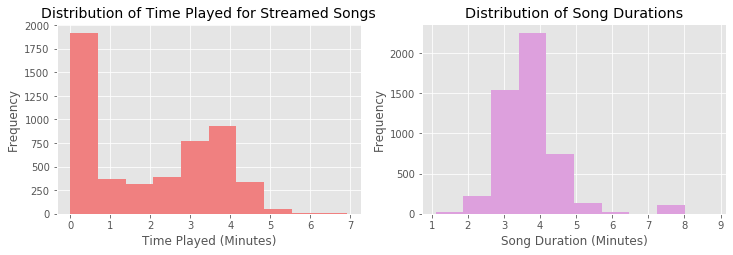

In [21]:
plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,3.5))
ax[0].hist(streaming_df["minutesPlayed"], color = "lightcoral")
ax[0].set_xlabel('Time Played (Minutes)')
ax[0].set_ylabel('Frequency')
ax[0].set_title('Distribution of Time Played for Streamed Songs', fontsize=14)


ax[1].hist(streaming_df["duration_min"], color = "plum")
ax[1].set_xlabel('Song Duration (Minutes)')
ax[1].set_ylabel('Frequency')
ax[1].set_title('Distribution of Song Durations');

I'm actually quite surprised to see how different the distribution of minutes I streamed a song for is from the distribution of song durations. The latter is roughly normally distributed while the former is right skewed, which goes to show how often I skip over songs. Of the 5000 songs that I streamed in the past year, I listened to about 2000 of them for less than 30 seconds!

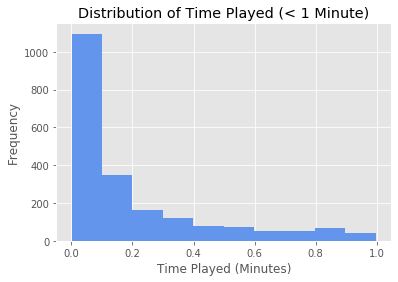

In [22]:
## get the minutes played for songs I played for less than a minute
mask = streaming_df["minutesPlayed"]<=1
tmp = streaming_df["minutesPlayed"][mask]

plt.hist(tmp, color = "cornflowerblue")
plt.title("Distribution of Time Played (< 1 Minute)")
plt.xlabel('Time Played (Minutes)')
plt.ylabel('Frequency');

Looking just at the songs that I played for less than a minute, it appears that the vast majority of them were skipped after playing for less than 6 seconds! 

Perhaps I should reconsider my Spotify subscription! Skipping about 40% of the songs recommended sounds a bit high to me, and I dislike these recommendations so much that I usually decide to skip in the first 6 seconds of the song. That being said, I can be somewhat picky with music (as you can probably imagine), so it's most likely not the algorithm's fault.

### Changes in Usage and Mood Across Time

There are two features I'm particularly interested in examining. In the aggregated data frame, I have the total monthly minutes played, as well as the average "valence" of the songs I played during that day. According to Spotify, valence is a feature that describes "the musical positiveness conveyed by a track". Valence ranges from 0-1, with 1 being more upbeat and 0 being more sad. By looking at valence over time, I can see how my mood changed throughout the past year.

In [23]:
## aggregate the data frame across months

aggregate_df = streaming_df.groupby('month').agg({
    'valence': [np.mean, np.std],
    'minutesPlayed': np.sum
        })

## rename column names to the following format: feature_aggregate function
aggregate_df.columns = ['_'.join(name) for name in aggregate_df.columns]
aggregate_df.reset_index(inplace=True)

In [24]:
aggregate_df.head()

,month,valence_mean,valence_std,minutesPlayed_sum
0,2019-07,0.554774,0.204491,410.583050
1,2019-08,0.554311,0.217872,1328.080417
2,2019-09,0.551948,0.189582,221.165317
3,2019-10,0.465154,0.204322,342.895350
4,2019-11,0.457729,0.225950,770.729583


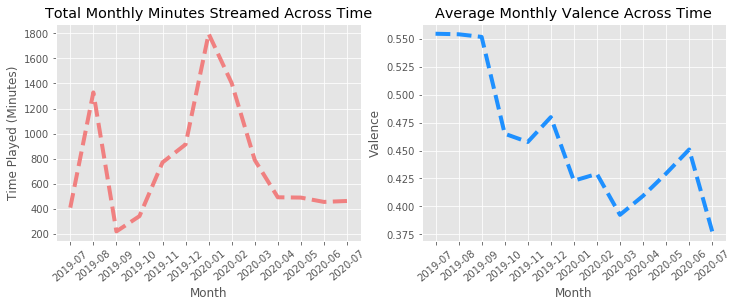

In [25]:
mpl.rcParams['lines.linewidth'] = 4
mpl.rcParams['lines.linestyle'] = '--'

plt.style.use('ggplot')
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (12,4))

ax[0].plot(aggregate_df["month"], aggregate_df["minutesPlayed_sum"], color = "lightcoral")
ax[0].set_xticklabels(labels = aggregate_df["month"], rotation=40)
ax[0].set_xlabel('Month')
ax[0].set_ylabel('Time Played (Minutes)')
ax[0].set_title('Total Monthly Minutes Streamed Across Time')

ax[1].plot(aggregate_df["month"], aggregate_df["valence_mean"], color = "dodgerblue")
ax[1].set_xticklabels(labels = aggregate_df["month"], rotation=40)
ax[1].set_xlabel('Month')
ax[1].set_ylabel('Valence')
ax[1].set_title('Average Monthly Valence Across Time');

Looking at the plots above, I can better understand my Spotify usage and mood across the previous 12 months. To give some context, I was working up until mid-August 2019, and quit my job to start graduate school in early September. 

Understandably, I saw a huge spike in time spent listening to music on Spotify in August, when I quit my job and had more free time on my hands. Then, when I started my graduate program, I hit an all time low (I remember being very busy re-adjusting to student life) and gradually increased my usage throughout the fall semester as I became more well-adjusted. January was my winter break, so naturally there was a spike in usage there, too, and it steadily decreased all the way to present day. It looks like in an average month (where I'm not too busy or too free), I stream songs for about 10 hours, so at \\$10/month I'm only paying \\$1/hour for Spotify's services.

The change in average monthly valence over time tells an interesting story. Clearly, my mood has been on a fairly steady decline over the past year. My mood was fairly positive from July to September, but I experienced a sharp drop in October (when the first wave of exams came around), and given how much Christmas music I listened to in December, I would have expected a much bigger uptick in December if it weren't for my final exams being around that time period too. There was another uptick in June (around the time I graduated from my program), but it was accompanied by a sharp drop once I started job searching!



### How Much Do I Actually Use Spotify?

To follow up on the total monthly minutes plot in the previous section, I'm curious to see if there are confounding factors that lead to misrepresentation of my Spotify usage. One possibility is that there are was simply an outlier during certain months (e.g. August, January) that drove up the entire month's total usage, while my usage was normal for the rest of the month.

In [26]:
aggregate_df = streaming_df.groupby('datePlayed').agg({'minutesPlayed': np.sum})
events = pd.Series(aggregate_df["minutesPlayed"])

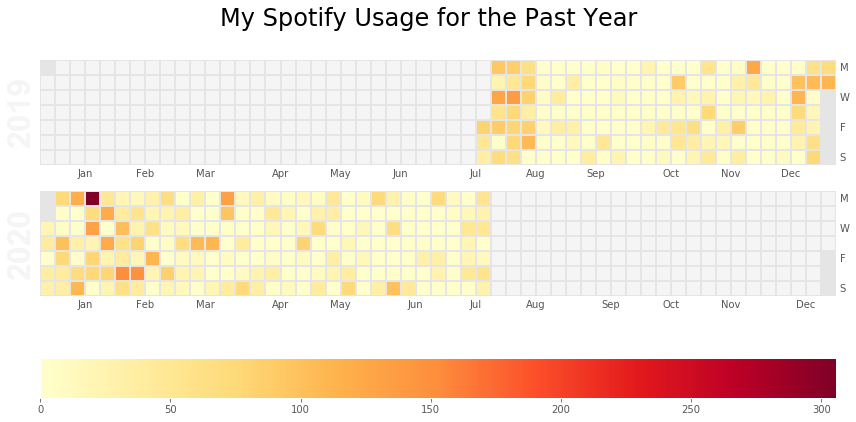

In [382]:
fig, ax = calmap.calendarplot(events, monthticks=1, daylabels='MTWTFSS', dayticks=[0, 2, 4, 6], 
                              cmap='YlOrRd', linewidth=1, fig_kws = {'figsize': (12, 6)})
fig.suptitle('My Spotify Usage for the Past Year', fontsize=24)
fig.colorbar(ax[0].get_children()[1], ax=ax.ravel().tolist(), orientation='horizontal');

Looking at the resulting calendar heatmap, it appears that there weren't any particular days that drove up the entire month's usage. My Spotify usage in the past year was fairly uniform, while the months that had higher monthly usage (August, January) contained consistently higher usage across several days, not just one. This means that there weren't any outliers that led to misrepresentation of my Spotify usage in the previous section. 


### How Different Are My Playlists?

I only have 8 playlists, but each of them falls into one of two categories: nostalgia and theme. 

1. Nostalgia: These playlists contain songs that I listened to frequently during a period of my life. For example, the playlist titled "Berkeley" contains the music that I listened to when I was at Berkeley. 
2. Theme: These playlists contain songs that fall into a certain theme. For example, the playlist titled "Zero to Hero" is my workout playlist and contain upbeat songs that I listen to during exercise. 

The playlists that fall under "theme" should definitely be very different in terms of music, but just how different are they in terms of the features that Spotify tracks? To do this, I will create radar charts for each playlist, based on 5 features: acousticness, valence, energy, danceability, and instrumentalness.

In [282]:
playlist_agg = playlist_df.groupby('name').agg({
    'energy': np.mean,
    'valence': np.mean,
    'acousticness': np.mean,
    'instrumentalness': np.mean,
    'danceability': np.mean
        })

In [346]:
names = playlist_agg.index
features = playlist_agg.columns
layout = dict(radialaxis = dict(range=[0, 1], showticklabels=False, ticks=''))

In [353]:
fig = make_subplots(rows=2, cols=4, subplot_titles=(names),
                    specs=[[{"type": "scatterpolar"}]*4, [{"type": "scatterpolar"}]*4],
                    horizontal_spacing=0.1, vertical_spacing = 0.1)

fig.add_trace(
    go.Scatterpolar(r = playlist_agg.loc[names[0],:], theta = features, fill='toself'),
    row=1, col=1
)

fig.add_trace(
    go.Scatterpolar(r = playlist_agg.loc[names[1],:], theta = features, fill='toself'),
    row=1, col=2
)

fig.add_trace(
    go.Scatterpolar(r = playlist_agg.loc[names[2],:], theta = features, fill='toself'),
    row=1, col=3
)

fig.add_trace(
    go.Scatterpolar(r = playlist_agg.loc[names[3],:], theta = features, fill='toself'),
    row=1, col=4
)

fig.add_trace(
    go.Scatterpolar(r = playlist_agg.loc[names[4],:], theta = features, fill='toself'),
    row=2, col=1
)

fig.add_trace(
    go.Scatterpolar(r = playlist_agg.loc[names[5],:], theta = features, fill='toself'),
    row=2, col=2
)

fig.add_trace(
    go.Scatterpolar(r = playlist_agg.loc[names[6],:], theta = features, fill='toself'),
    row=2, col=3
)

fig.add_trace(
    go.Scatterpolar(r = playlist_agg.loc[names[7],:], theta = features, fill='toself'),
    row=2, col=4
)

fig.update_layout(height=700, width=1300, title_text="Playlist Radar Charts", showlegend=False,
                 polar = layout, polar2 = layout, polar3 = layout, polar4 = layout, polar5 = layout, 
                 polar6 = layout, polar7 = layout, polar8 = layout)

fig.show()

Surprisingly, all of my "nostalgia" playlists follow the same general shape! They don't contain many instrumental (i.e. no lyrics) music, have low valence and energy, are highly acoustic, and have medium danceability. This means that throughout the years, my tastes in music have stayed consistent!

Similarly, my "theme" playlists follow the same shape. For context, the playlist "K-pop bops" contains Korean pop music and the playlist "Zero to Hero" contains workout music. These playlists tend to be high energy, highly danceable, have medium valence, and low acousticness and instrumentalness. This is to be expected, since these are the playlists that I listen to during long drives and tough workouts!


### Bonus: Using Machine Learning to Generate Better Recommendations
Since I noticed the Spotify algorithm isn't really working for me and that the music that I save to my playlists tend to have the same traits on average, I'd like to try to build a model that can better feel out my tastes. I have low expectations for this since Spotify has a dedicated data science team full of more experienced data scientists, but let's see how it goes.

WIP. Will update once model performance is optimized.